# Training Transformer

### TA's Slide
[Slide](https://docs.google.com/presentation/d/1ga0d43mWyrfHjdkp7FG3iWcEKTGr8CdkifYhhi4LBY8/edit?usp=sharing)

### Description
In this assignment, we are tasked with utilizing a transformer decoder-only architecture for pretraining, with a focus on next-token prediction, applied to Pokémon images.

Please feel free to mail us if you have any questions.

ntu-ml-2025-spring-ta@googlegroups.com

# Utilities

### Download packages

In [1]:
!pip install datasets==3.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

### Import Packages

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import set_seed
from datasets import load_dataset


### Check Devices

In [3]:
!nvidia-smi

Mon Apr  7 06:25:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Set Random Seed

In [4]:
set_seed(0)

# Prepare Data

### Define Dataset

In [5]:
from typing import List, Tuple, Union
import torch
from torch.utils.data import Dataset

class PixelSequenceDataset(Dataset):
    def __init__(self, data: List[List[int]], mode: str = "train"):
        """
        A dataset class for handling pixel sequences.

        Args:
            data (List[List[int]]): A list of sequences, where each sequence is a list of integers.
            mode (str): The mode of operation, either "train", "dev", or "test".
                - "train": Returns (input_ids, labels) where input_ids are sequence[:-1] and labels are sequence[1:].
                - "dev": Returns (input_ids, labels) where input_ids are sequence[:-160] and labels are sequence[-160:].
                - "test": Returns only input_ids, as labels are not available.
        """
        self.data = data
        self.mode = mode

    def __len__(self) -> int:
        """Returns the total number of sequences in the dataset."""
        return len(self.data)

    def __getitem__(self, idx: int) -> Union[Tuple[torch.Tensor, torch.Tensor], torch.Tensor]:
        """
        Fetches a sequence from the dataset and processes it based on the mode.

        Args:
            idx (int): The index of the sequence.

        Returns:
            - If mode == "train": Tuple[torch.Tensor, torch.Tensor] -> (input_ids, labels)
            - If mode == "dev": Tuple[torch.Tensor, torch.Tensor] -> (input_ids, labels)
            - If mode == "test": torch.Tensor -> input_ids
        """
        sequence = self.data[idx]

        if self.mode == "train":
            input_ids = torch.tensor(sequence[:-1], dtype=torch.long)
            labels = torch.tensor(sequence[1:], dtype=torch.long)
            return input_ids, labels

        elif self.mode == "dev":
            input_ids = torch.tensor(sequence[:-160], dtype=torch.long)
            labels = torch.tensor(sequence[-160:], dtype=torch.long)
            return input_ids, labels

        elif self.mode == "test":
            input_ids = torch.tensor(sequence, dtype=torch.long)
            return input_ids

        raise ValueError(f"Invalid mode: {self.mode}. Choose from 'train', 'dev', or 'test'.")

### Download Dataset & Prepare Dataloader

In [6]:
# Load the pokemon dataset from Hugging Face Hub
pokemon_dataset = load_dataset("lca0503/ml2025-hw4-pokemon")

# Load the colormap from Hugging Face Hub
colormap = list(load_dataset("lca0503/ml2025-hw4-colormap")["train"]["color"])

# Define number of classes
num_classes = len(colormap)

# Define batch size
batch_size = 32
epochs = 200                       # 增加到 200，確保充分收斂
learning_rate = 1e-4               # 進一步降低學習率，穩定訓練
warmup_steps = 200                 # 增加 warmup 步數
weight_decay = 0.05                # 增加正則化，減少過擬合
gradient_clip = 1.0                # 添加梯度裁剪，避免梯度爆炸
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# === Prepare Dataset and DataLoader for Training ===
train_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["train"]["pixel_color"], mode="train"
)
train_dataloader: DataLoader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

# === Prepare Dataset and DataLoader for Validation ===
dev_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["dev"]["pixel_color"], mode="dev"
)
dev_dataloader: DataLoader = DataLoader(
    dev_dataset, batch_size=batch_size, shuffle=False
)

# === Prepare Dataset and DataLoader for Testing ===
test_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["test"]["pixel_color"], mode="test"
)
test_dataloader: DataLoader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/501 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/175k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/23.4k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/632 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/80 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/80 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/297 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/167 [00:00<?, ? examples/s]

### Visualization

In [7]:
def pixel_to_image(pixel_color: List[int], colormap: List[List[int]]) -> Image.Image:
    """
    Converts a list of pixel indices into a 20x20 RGB image using a colormap.

    Args:
        pixel_color (List[int]): A list of pixel indices representing colors.
        colormap (List[List[int]]): A list where each index maps to an RGB color [R, G, B].

    Returns:
        Image.Image: A PIL Image object representing the reconstructed image.
    """
    # Ensure the pixel_color list has at least 400 elements (pad with 0s if needed)
    while len(pixel_color) < 400:
        pixel_color.append(0)

    # Map pixel indices to actual RGB colors using the colormap
    pixel_data = [colormap[pixel] for pixel in pixel_color]

    # Convert to numpy array and reshape to 20x20x3 (RGB image)
    image_array = np.array(pixel_data, dtype=np.uint8).reshape(20, 20, 3)

    # Create a PIL Image from the array
    image = Image.fromarray(image_array)

    return image

def show_images(images: List[Image.Image]) -> None:
    """
    Displays a grid of up to 96 images using Matplotlib.

    Args:
        images (List[Image.Image]): A list of PIL Image objects to display.

    Returns:
        None
    """
    num_images = min(96, len(images))  # Limit to 96 images

    # Set up the figure size and grid layout (6 rows, 16 columns)
    fig, axes = plt.subplots(6, 16, figsize=(16, 6))
    axes = axes.flatten()  # Flatten to make iteration easier

    # Loop through images and display each one in the grid
    for i, ax in enumerate(axes):
        if i < num_images:
            ax.imshow(images[i])
            ax.axis('off')  # Hide axis
        else:
            ax.axis('off')  # Hide unused subplots

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

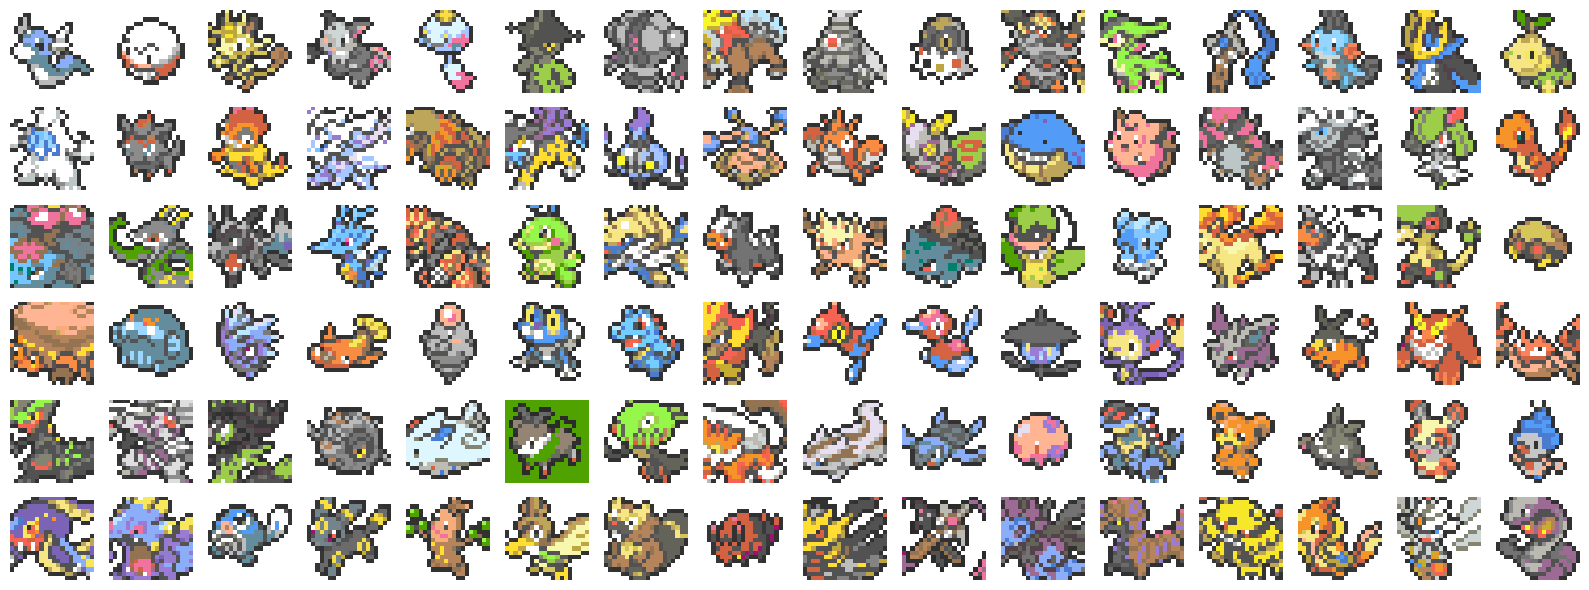

In [8]:
# Visualize train images
train_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["train"]]
show_images(train_images)

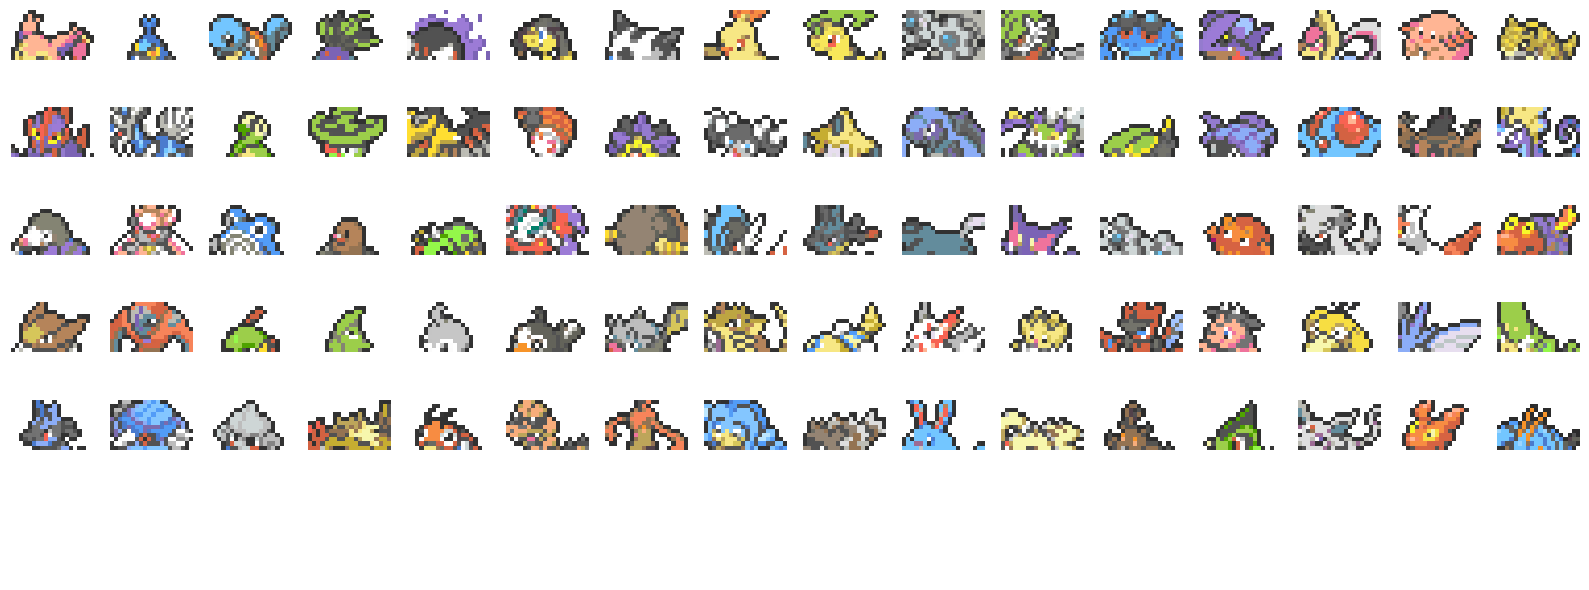

In [9]:
# Visualize test images
test_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["test"]]
show_images(test_images)

# Prepare Model

### Model Configuration
Here, we define the model configuration, including the architecture and key hyperparameters such as the number of attention heads, layers, embedding size, and more.
*   Hint 1: Adjust hyperparameters here for improved performance.
*   Hint 2: Experiment with different model architectures, such as Llama, Mistral, or Qwen, to enhance performance.
  * [LlamaConfig](https://huggingface.co/docs/transformers/model_doc/llama#transformers.LlamaConfig)
  * [MistralConfig](https://huggingface.co/docs/transformers/model_doc/mistral#transformers.MistralConfig)
  * [Qwen2Config](https://huggingface.co/docs/transformers/model_doc/qwen2#transformers.Qwen2Config)


In [10]:
from transformers import Qwen2Config, AutoModelForCausalLM

qwen2_config = {
    "hidden_act": "gelu_new",          # 保持 GELU，與 Mistral 一致
    "architectures": ["Qwen2ForCausalLM"],
    "attention_dropout": 0.02,         # 降低 dropout，提升模型穩定性
    "hidden_dropout_prob": 0.02,       # 降低 dropout，提升模型穩定性
    "initializer_range": 0.02,
    "layer_norm_eps": 1e-05,
    "model_type": "qwen2",
    "max_position_embeddings": 400,
    "hidden_size": 384,                # 進一步增加到 384，提升模型容量
    "num_attention_heads": 12,         # 增加到 12，與 hidden_size 匹配
    "num_hidden_layers": 12,            # 增加到 8，進一步提升模型深度
    "vocab_size": num_classes,
    "pad_token_id": None,
    "eos_token_id": None,
    "intermediate_size": 1536,         # 設為 hidden_size 的 4 倍
    "num_key_value_heads": 12,         # 與 num_attention_heads 一致，禁用 GQA
}

# 使用 Qwen2Config 創建配置
config = Qwen2Config.from_dict(qwen2_config)


### Load Model

In [11]:
# Load the model using the configuration defined above
model = AutoModelForCausalLM.from_config(config)

print(model)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable Parameters: {trainable_params:,}")

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(167, 384)
    (layers): ModuleList(
      (0-7): 8 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=384, out_features=384, bias=True)
          (k_proj): Linear(in_features=384, out_features=384, bias=True)
          (v_proj): Linear(in_features=384, out_features=384, bias=True)
          (o_proj): Linear(in_features=384, out_features=384, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=384, out_features=1536, bias=False)
          (up_proj): Linear(in_features=384, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=384, bias=False)
          (act_fn): NewGELUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((384,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((384,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((384,), eps=1e-06)
    (rotary_emb): Qwen2Ro

# Train and Inference

### Training Arguments
Here, we define the number of epochs for training, the learning rate, the optimizer, and the loss function.
*   Hint 3: Adjust the number of epochs and learning rate here to improve performance.

In [12]:
from torch.optim.lr_scheduler import CosineAnnealingLR
# Training Parameters
epochs = 200                                      # Number of training epochs
learning_rate = 1e-4
# 優化器和學習率調度
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    total_steps=epochs * len(train_dataloader),
    pct_start=0.1  # 10% 的步數用於 warmup
)
scaler = torch.cuda.amp.GradScaler()
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
# 在每個 epoch 結束後更新學習率
scheduler.step()                            # Learning rate for optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")     # Check if CUDA is available for GPU
save_dir = "checkpoints"                               # Directory to save model checkpoints

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()                          # Loss function for classification tasks
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1) # AdamW optimizer with weight decay

<ipython-input-12-ec72c8b3bc53>:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


### Save Model Function

In [13]:
def save_model(model: torch.nn.Module, optimizer: torch.optim.Optimizer, epoch: int, loss: float, save_dir: str, filename: str = "best_model.pth") -> None:
    """
    Saves the model state, optimizer state, current epoch, and loss to a specified directory.

    Args:
        model (torch.nn.Module): The PyTorch model to be saved.
        optimizer (torch.optim.Optimizer): The optimizer whose state will be saved.
        epoch (int): The current epoch number (used for checkpointing).
        loss (float): The current loss value to track model performance.
        save_dir (str): The directory where the model checkpoint will be saved.
        filename (str, optional): The name of the file to save the model. Defaults to "best_model.pth".

    Returns:
        None
    """
    # Construct the full path for saving the model checkpoint
    save_path = os.path.join(save_dir, filename)

    # Save the model, optimizer state, and additional metadata (epoch and loss)
    torch.save({
        'epoch': epoch + 1,                # Save epoch + 1 for easier tracking
        'model_state_dict': model.state_dict(),       # Save model weights
        'optimizer_state_dict': optimizer.state_dict(),  # Save optimizer state (important for resuming training)
        'loss': loss                     # Save the current loss value
    }, save_path)

    # Print a confirmation message indicating the model has been saved
    print(f"Model saved at {save_path} (Loss: {loss:.4f}, Epoch: {epoch + 1})")

### Train

We save the checkpoint with the lowest training loss since validation set reconstruction accuracy doesn't directly reflect the model's image generation quality.
*   Hint 4: Train a classifier to check if an image looks like a Pokémon or not. (Optional)

In [14]:
# Create save directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)
# Initialize best loss as positive infinity for comparison during model checkpointing
best_loss: float = float('inf')
# Move model to the appropriate device (GPU or CPU)
model.to(device)

# Training Loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0  # Initialize the epoch loss

    # Iterate over training data batches
    for input_ids, labels in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
        input_ids, labels = input_ids.to(device), labels.to(device)  # Move data to the same device as the model

        # Forward pass through the model to get logits (output probabilities)
        outputs = model(input_ids=input_ids).logits.view(-1, config.vocab_size)
        labels = labels.view(-1)  # Flatten labels to match logits shape

        # Calculate loss using CrossEntropyLoss
        loss = criterion(outputs, labels)

        # Backpropagation and optimizer step
        optimizer.zero_grad()  # Reset gradients to zero
        loss.backward()     # Compute gradients
        optimizer.step()     # Update model weights

        # Accumulate the loss for the epoch
        epoch_loss += loss.item()

    # Compute average epoch loss
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss:.4f}")

    # Evaluation Loop (Validation)
    model.eval()      # Set the model to evaluation mode (disables dropout, etc.)
    total_accuracy = 0  # Initialize total accuracy
    num_batches = 0   # Initialize batch counter

    with torch.no_grad():  # Disable gradient calculation for validation
        # Iterate over validation data batches
        for inputs, labels in tqdm(dev_dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)  # Move validation data to device
            attention_mask = torch.ones_like(inputs)          # Attention mask to ensure valid token positions

            # Perform batch inference using the model
            generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)

            # Extract the last 160 tokens from generated outputs and labels
            generated_outputs = generated_outputs[:, -160:]

            # Calculate accuracy for the batch
            accuracy = (generated_outputs == labels).float().mean().item()
            total_accuracy += accuracy
            num_batches += 1

    # Compute average reconstruction accuracy for the epoch
    avg_accuracy = total_accuracy / num_batches
    print(f"Epoch {epoch + 1}/{epochs}, Reconstruction Accuracy: {avg_accuracy:.4f}")

    # If the current epoch loss is better (lower) than the best loss, save the model
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss                   # Update best loss
        save_model(model, optimizer, epoch, best_loss, save_dir)  # Save the model with the best loss

Training Epoch 1/200: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch 1/200, Loss: 3.6221


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


Epoch 1/200, Reconstruction Accuracy: 0.3576
Model saved at checkpoints/best_model.pth (Loss: 3.6221, Epoch: 1)


Training Epoch 2/200: 100%|██████████| 20/20 [00:13<00:00,  1.51it/s]


Epoch 2/200, Loss: 3.0514


Evaluating: 100%|██████████| 3/3 [00:08<00:00,  2.93s/it]


Epoch 2/200, Reconstruction Accuracy: 0.3598
Model saved at checkpoints/best_model.pth (Loss: 3.0514, Epoch: 2)


Training Epoch 3/200: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Epoch 3/200, Loss: 2.6848


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


Epoch 3/200, Reconstruction Accuracy: 0.3630
Model saved at checkpoints/best_model.pth (Loss: 2.6848, Epoch: 3)


Training Epoch 4/200: 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]


Epoch 4/200, Loss: 2.4065


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Epoch 4/200, Reconstruction Accuracy: 0.3706
Model saved at checkpoints/best_model.pth (Loss: 2.4065, Epoch: 4)


Training Epoch 5/200: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch 5/200, Loss: 2.1776


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch 5/200, Reconstruction Accuracy: 0.2758
Model saved at checkpoints/best_model.pth (Loss: 2.1776, Epoch: 5)


Training Epoch 6/200: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch 6/200, Loss: 2.0181


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


Epoch 6/200, Reconstruction Accuracy: 0.2809
Model saved at checkpoints/best_model.pth (Loss: 2.0181, Epoch: 6)


Training Epoch 7/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 7/200, Loss: 1.8939


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


Epoch 7/200, Reconstruction Accuracy: 0.2407
Model saved at checkpoints/best_model.pth (Loss: 1.8939, Epoch: 7)


Training Epoch 8/200: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch 8/200, Loss: 1.7867


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


Epoch 8/200, Reconstruction Accuracy: 0.2124
Model saved at checkpoints/best_model.pth (Loss: 1.7867, Epoch: 8)


Training Epoch 9/200: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch 9/200, Loss: 1.7040


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 9/200, Reconstruction Accuracy: 0.2911
Model saved at checkpoints/best_model.pth (Loss: 1.7040, Epoch: 9)


Training Epoch 10/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 10/200, Loss: 1.6303


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


Epoch 10/200, Reconstruction Accuracy: 0.3180
Model saved at checkpoints/best_model.pth (Loss: 1.6303, Epoch: 10)


Training Epoch 11/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 11/200, Loss: 1.5631


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


Epoch 11/200, Reconstruction Accuracy: 0.3333
Model saved at checkpoints/best_model.pth (Loss: 1.5631, Epoch: 11)


Training Epoch 12/200: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch 12/200, Loss: 1.5085


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch 12/200, Reconstruction Accuracy: 0.3470
Model saved at checkpoints/best_model.pth (Loss: 1.5085, Epoch: 12)


Training Epoch 13/200: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch 13/200, Loss: 1.4583


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.84s/it]


Epoch 13/200, Reconstruction Accuracy: 0.3407
Model saved at checkpoints/best_model.pth (Loss: 1.4583, Epoch: 13)


Training Epoch 14/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 14/200, Loss: 1.4150


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


Epoch 14/200, Reconstruction Accuracy: 0.3418
Model saved at checkpoints/best_model.pth (Loss: 1.4150, Epoch: 14)


Training Epoch 15/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 15/200, Loss: 1.3775


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 15/200, Reconstruction Accuracy: 0.3443
Model saved at checkpoints/best_model.pth (Loss: 1.3775, Epoch: 15)


Training Epoch 16/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 16/200, Loss: 1.3367


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


Epoch 16/200, Reconstruction Accuracy: 0.3241
Model saved at checkpoints/best_model.pth (Loss: 1.3367, Epoch: 16)


Training Epoch 17/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 17/200, Loss: 1.2935


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


Epoch 17/200, Reconstruction Accuracy: 0.3518
Model saved at checkpoints/best_model.pth (Loss: 1.2935, Epoch: 17)


Training Epoch 18/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 18/200, Loss: 1.2485


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 18/200, Reconstruction Accuracy: 0.3667
Model saved at checkpoints/best_model.pth (Loss: 1.2485, Epoch: 18)


Training Epoch 19/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 19/200, Loss: 1.2109


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


Epoch 19/200, Reconstruction Accuracy: 0.3347
Model saved at checkpoints/best_model.pth (Loss: 1.2109, Epoch: 19)


Training Epoch 20/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 20/200, Loss: 1.1664


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


Epoch 20/200, Reconstruction Accuracy: 0.3331
Model saved at checkpoints/best_model.pth (Loss: 1.1664, Epoch: 20)


Training Epoch 21/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 21/200, Loss: 1.1297


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 21/200, Reconstruction Accuracy: 0.3339
Model saved at checkpoints/best_model.pth (Loss: 1.1297, Epoch: 21)


Training Epoch 22/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 22/200, Loss: 1.0960


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch 22/200, Reconstruction Accuracy: 0.3357
Model saved at checkpoints/best_model.pth (Loss: 1.0960, Epoch: 22)


Training Epoch 23/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 23/200, Loss: 1.0618


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.91s/it]


Epoch 23/200, Reconstruction Accuracy: 0.3615
Model saved at checkpoints/best_model.pth (Loss: 1.0618, Epoch: 23)


Training Epoch 24/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 24/200, Loss: 1.0119


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


Epoch 24/200, Reconstruction Accuracy: 0.3570
Model saved at checkpoints/best_model.pth (Loss: 1.0119, Epoch: 24)


Training Epoch 25/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 25/200, Loss: 0.9505


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


Epoch 25/200, Reconstruction Accuracy: 0.3552
Model saved at checkpoints/best_model.pth (Loss: 0.9505, Epoch: 25)


Training Epoch 26/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 26/200, Loss: 0.9054


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.95s/it]


Epoch 26/200, Reconstruction Accuracy: 0.3398
Model saved at checkpoints/best_model.pth (Loss: 0.9054, Epoch: 26)


Training Epoch 27/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 27/200, Loss: 0.8667


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


Epoch 27/200, Reconstruction Accuracy: 0.3399
Model saved at checkpoints/best_model.pth (Loss: 0.8667, Epoch: 27)


Training Epoch 28/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 28/200, Loss: 0.8269


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


Epoch 28/200, Reconstruction Accuracy: 0.3202
Model saved at checkpoints/best_model.pth (Loss: 0.8269, Epoch: 28)


Training Epoch 29/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 29/200, Loss: 0.7938


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.95s/it]


Epoch 29/200, Reconstruction Accuracy: 0.3363
Model saved at checkpoints/best_model.pth (Loss: 0.7938, Epoch: 29)


Training Epoch 30/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 30/200, Loss: 0.7382


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Epoch 30/200, Reconstruction Accuracy: 0.3478
Model saved at checkpoints/best_model.pth (Loss: 0.7382, Epoch: 30)


Training Epoch 31/200: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch 31/200, Loss: 0.6793


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.93s/it]


Epoch 31/200, Reconstruction Accuracy: 0.3225
Model saved at checkpoints/best_model.pth (Loss: 0.6793, Epoch: 31)


Training Epoch 32/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 32/200, Loss: 0.6239


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.93s/it]


Epoch 32/200, Reconstruction Accuracy: 0.3548
Model saved at checkpoints/best_model.pth (Loss: 0.6239, Epoch: 32)


Training Epoch 33/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 33/200, Loss: 0.5833


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch 33/200, Reconstruction Accuracy: 0.3513
Model saved at checkpoints/best_model.pth (Loss: 0.5833, Epoch: 33)


Training Epoch 34/200: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch 34/200, Loss: 0.5430


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch 34/200, Reconstruction Accuracy: 0.3507
Model saved at checkpoints/best_model.pth (Loss: 0.5430, Epoch: 34)


Training Epoch 35/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 35/200, Loss: 0.4952


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.94s/it]


Epoch 35/200, Reconstruction Accuracy: 0.3287
Model saved at checkpoints/best_model.pth (Loss: 0.4952, Epoch: 35)


Training Epoch 36/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 36/200, Loss: 0.4535


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch 36/200, Reconstruction Accuracy: 0.3299
Model saved at checkpoints/best_model.pth (Loss: 0.4535, Epoch: 36)


Training Epoch 37/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 37/200, Loss: 0.4170


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


Epoch 37/200, Reconstruction Accuracy: 0.3294
Model saved at checkpoints/best_model.pth (Loss: 0.4170, Epoch: 37)


Training Epoch 38/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 38/200, Loss: 0.3741


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.91s/it]


Epoch 38/200, Reconstruction Accuracy: 0.3463
Model saved at checkpoints/best_model.pth (Loss: 0.3741, Epoch: 38)


Training Epoch 39/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 39/200, Loss: 0.3443


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch 39/200, Reconstruction Accuracy: 0.3484
Model saved at checkpoints/best_model.pth (Loss: 0.3443, Epoch: 39)


Training Epoch 40/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 40/200, Loss: 0.3149


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch 40/200, Reconstruction Accuracy: 0.3309
Model saved at checkpoints/best_model.pth (Loss: 0.3149, Epoch: 40)


Training Epoch 41/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 41/200, Loss: 0.2924


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


Epoch 41/200, Reconstruction Accuracy: 0.3558
Model saved at checkpoints/best_model.pth (Loss: 0.2924, Epoch: 41)


Training Epoch 42/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 42/200, Loss: 0.2589


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch 42/200, Reconstruction Accuracy: 0.3402
Model saved at checkpoints/best_model.pth (Loss: 0.2589, Epoch: 42)


Training Epoch 43/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 43/200, Loss: 0.2292


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


Epoch 43/200, Reconstruction Accuracy: 0.3505
Model saved at checkpoints/best_model.pth (Loss: 0.2292, Epoch: 43)


Training Epoch 44/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 44/200, Loss: 0.2046


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.93s/it]


Epoch 44/200, Reconstruction Accuracy: 0.3566
Model saved at checkpoints/best_model.pth (Loss: 0.2046, Epoch: 44)


Training Epoch 45/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 45/200, Loss: 0.1817


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch 45/200, Reconstruction Accuracy: 0.3471
Model saved at checkpoints/best_model.pth (Loss: 0.1817, Epoch: 45)


Training Epoch 46/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 46/200, Loss: 0.1681


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


Epoch 46/200, Reconstruction Accuracy: 0.3619
Model saved at checkpoints/best_model.pth (Loss: 0.1681, Epoch: 46)


Training Epoch 47/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 47/200, Loss: 0.1541


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


Epoch 47/200, Reconstruction Accuracy: 0.3453
Model saved at checkpoints/best_model.pth (Loss: 0.1541, Epoch: 47)


Training Epoch 48/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 48/200, Loss: 0.1399


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 48/200, Reconstruction Accuracy: 0.3539
Model saved at checkpoints/best_model.pth (Loss: 0.1399, Epoch: 48)


Training Epoch 49/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 49/200, Loss: 0.1318


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch 49/200, Reconstruction Accuracy: 0.3505
Model saved at checkpoints/best_model.pth (Loss: 0.1318, Epoch: 49)


Training Epoch 50/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 50/200, Loss: 0.1206


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


Epoch 50/200, Reconstruction Accuracy: 0.3434
Model saved at checkpoints/best_model.pth (Loss: 0.1206, Epoch: 50)


Training Epoch 51/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 51/200, Loss: 0.1094


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch 51/200, Reconstruction Accuracy: 0.3622
Model saved at checkpoints/best_model.pth (Loss: 0.1094, Epoch: 51)


Training Epoch 52/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 52/200, Loss: 0.0977


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch 52/200, Reconstruction Accuracy: 0.3376
Model saved at checkpoints/best_model.pth (Loss: 0.0977, Epoch: 52)


Training Epoch 53/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 53/200, Loss: 0.0892


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


Epoch 53/200, Reconstruction Accuracy: 0.3436
Model saved at checkpoints/best_model.pth (Loss: 0.0892, Epoch: 53)


Training Epoch 54/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 54/200, Loss: 0.0802


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 54/200, Reconstruction Accuracy: 0.3436
Model saved at checkpoints/best_model.pth (Loss: 0.0802, Epoch: 54)


Training Epoch 55/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 55/200, Loss: 0.0769


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch 55/200, Reconstruction Accuracy: 0.3458
Model saved at checkpoints/best_model.pth (Loss: 0.0769, Epoch: 55)


Training Epoch 56/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 56/200, Loss: 0.0755


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


Epoch 56/200, Reconstruction Accuracy: 0.3495
Model saved at checkpoints/best_model.pth (Loss: 0.0755, Epoch: 56)


Training Epoch 57/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 57/200, Loss: 0.0719


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 57/200, Reconstruction Accuracy: 0.3215
Model saved at checkpoints/best_model.pth (Loss: 0.0719, Epoch: 57)


Training Epoch 58/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 58/200, Loss: 0.0742


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


Epoch 58/200, Reconstruction Accuracy: 0.3493


Training Epoch 59/200: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch 59/200, Loss: 0.0685


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


Epoch 59/200, Reconstruction Accuracy: 0.3380
Model saved at checkpoints/best_model.pth (Loss: 0.0685, Epoch: 59)


Training Epoch 60/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 60/200, Loss: 0.0615


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Epoch 60/200, Reconstruction Accuracy: 0.3601
Model saved at checkpoints/best_model.pth (Loss: 0.0615, Epoch: 60)


Training Epoch 61/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 61/200, Loss: 0.0596


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.79s/it]


Epoch 61/200, Reconstruction Accuracy: 0.3548
Model saved at checkpoints/best_model.pth (Loss: 0.0596, Epoch: 61)


Training Epoch 62/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 62/200, Loss: 0.0565


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


Epoch 62/200, Reconstruction Accuracy: 0.3431
Model saved at checkpoints/best_model.pth (Loss: 0.0565, Epoch: 62)


Training Epoch 63/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 63/200, Loss: 0.0539


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 63/200, Reconstruction Accuracy: 0.3443
Model saved at checkpoints/best_model.pth (Loss: 0.0539, Epoch: 63)


Training Epoch 64/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 64/200, Loss: 0.0512


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.79s/it]


Epoch 64/200, Reconstruction Accuracy: 0.3587
Model saved at checkpoints/best_model.pth (Loss: 0.0512, Epoch: 64)


Training Epoch 65/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 65/200, Loss: 0.0486


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


Epoch 65/200, Reconstruction Accuracy: 0.3510
Model saved at checkpoints/best_model.pth (Loss: 0.0486, Epoch: 65)


Training Epoch 66/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 66/200, Loss: 0.0478


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch 66/200, Reconstruction Accuracy: 0.3487
Model saved at checkpoints/best_model.pth (Loss: 0.0478, Epoch: 66)


Training Epoch 67/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 67/200, Loss: 0.0473


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


Epoch 67/200, Reconstruction Accuracy: 0.3486
Model saved at checkpoints/best_model.pth (Loss: 0.0473, Epoch: 67)


Training Epoch 68/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 68/200, Loss: 0.0461


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch 68/200, Reconstruction Accuracy: 0.3574
Model saved at checkpoints/best_model.pth (Loss: 0.0461, Epoch: 68)


Training Epoch 69/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 69/200, Loss: 0.0453


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 69/200, Reconstruction Accuracy: 0.3460
Model saved at checkpoints/best_model.pth (Loss: 0.0453, Epoch: 69)


Training Epoch 70/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 70/200, Loss: 0.0464


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.81s/it]


Epoch 70/200, Reconstruction Accuracy: 0.3572


Training Epoch 71/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 71/200, Loss: 0.0453


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


Epoch 71/200, Reconstruction Accuracy: 0.3534
Model saved at checkpoints/best_model.pth (Loss: 0.0453, Epoch: 71)


Training Epoch 72/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 72/200, Loss: 0.0457


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch 72/200, Reconstruction Accuracy: 0.3531


Training Epoch 73/200: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch 73/200, Loss: 0.0443


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch 73/200, Reconstruction Accuracy: 0.3476
Model saved at checkpoints/best_model.pth (Loss: 0.0443, Epoch: 73)


Training Epoch 74/200: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch 74/200, Loss: 0.0429


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.81s/it]


Epoch 74/200, Reconstruction Accuracy: 0.3484
Model saved at checkpoints/best_model.pth (Loss: 0.0429, Epoch: 74)


Training Epoch 75/200: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch 75/200, Loss: 0.0394


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


Epoch 75/200, Reconstruction Accuracy: 0.3600
Model saved at checkpoints/best_model.pth (Loss: 0.0394, Epoch: 75)


Training Epoch 76/200: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch 76/200, Loss: 0.0398


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 76/200, Reconstruction Accuracy: 0.3438


Training Epoch 77/200: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch 77/200, Loss: 0.0381


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch 77/200, Reconstruction Accuracy: 0.3576
Model saved at checkpoints/best_model.pth (Loss: 0.0381, Epoch: 77)


Training Epoch 78/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 78/200, Loss: 0.0369


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


Epoch 78/200, Reconstruction Accuracy: 0.3528
Model saved at checkpoints/best_model.pth (Loss: 0.0369, Epoch: 78)


Training Epoch 79/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 79/200, Loss: 0.0373


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 79/200, Reconstruction Accuracy: 0.3378


Training Epoch 80/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 80/200, Loss: 0.0374


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


Epoch 80/200, Reconstruction Accuracy: 0.3417


Training Epoch 81/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 81/200, Loss: 0.0388


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch 81/200, Reconstruction Accuracy: 0.3426


Training Epoch 82/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 82/200, Loss: 0.0405


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 82/200, Reconstruction Accuracy: 0.3492


Training Epoch 83/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 83/200, Loss: 0.0436


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch 83/200, Reconstruction Accuracy: 0.3611


Training Epoch 84/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 84/200, Loss: 0.0473


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


Epoch 84/200, Reconstruction Accuracy: 0.3495


Training Epoch 85/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 85/200, Loss: 0.0521


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.84s/it]


Epoch 85/200, Reconstruction Accuracy: 0.3538


Training Epoch 86/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 86/200, Loss: 0.0618


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


Epoch 86/200, Reconstruction Accuracy: 0.3645


Training Epoch 87/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 87/200, Loss: 0.0694


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


Epoch 87/200, Reconstruction Accuracy: 0.3438


Training Epoch 88/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 88/200, Loss: 0.0725


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch 88/200, Reconstruction Accuracy: 0.3495


Training Epoch 89/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 89/200, Loss: 0.0790


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 89/200, Reconstruction Accuracy: 0.3468


Training Epoch 90/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 90/200, Loss: 0.0838


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


Epoch 90/200, Reconstruction Accuracy: 0.3540


Training Epoch 91/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 91/200, Loss: 0.0841


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


Epoch 91/200, Reconstruction Accuracy: 0.3508


Training Epoch 92/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 92/200, Loss: 0.0879


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 92/200, Reconstruction Accuracy: 0.3602


Training Epoch 93/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 93/200, Loss: 0.0850


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


Epoch 93/200, Reconstruction Accuracy: 0.3484


Training Epoch 94/200: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch 94/200, Loss: 0.0775


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.81s/it]


Epoch 94/200, Reconstruction Accuracy: 0.3566


Training Epoch 95/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 95/200, Loss: 0.0698


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 95/200, Reconstruction Accuracy: 0.3570


Training Epoch 96/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 96/200, Loss: 0.0617


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch 96/200, Reconstruction Accuracy: 0.3564


Training Epoch 97/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 97/200, Loss: 0.0506


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


Epoch 97/200, Reconstruction Accuracy: 0.3391


Training Epoch 98/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 98/200, Loss: 0.0441


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


Epoch 98/200, Reconstruction Accuracy: 0.3505


Training Epoch 99/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 99/200, Loss: 0.0396


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


Epoch 99/200, Reconstruction Accuracy: 0.3563


Training Epoch 100/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 100/200, Loss: 0.0351


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


Epoch 100/200, Reconstruction Accuracy: 0.3626
Model saved at checkpoints/best_model.pth (Loss: 0.0351, Epoch: 100)


Training Epoch 101/200: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch 101/200, Loss: 0.0320


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 101/200, Reconstruction Accuracy: 0.3717
Model saved at checkpoints/best_model.pth (Loss: 0.0320, Epoch: 101)


Training Epoch 102/200: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch 102/200, Loss: 0.0298


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.81s/it]


Epoch 102/200, Reconstruction Accuracy: 0.3522
Model saved at checkpoints/best_model.pth (Loss: 0.0298, Epoch: 102)


Training Epoch 103/200: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch 103/200, Loss: 0.0286


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch 103/200, Reconstruction Accuracy: 0.3462
Model saved at checkpoints/best_model.pth (Loss: 0.0286, Epoch: 103)


Training Epoch 104/200: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch 104/200, Loss: 0.0269


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch 104/200, Reconstruction Accuracy: 0.3581
Model saved at checkpoints/best_model.pth (Loss: 0.0269, Epoch: 104)


Training Epoch 105/200: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch 105/200, Loss: 0.0246


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


Epoch 105/200, Reconstruction Accuracy: 0.3538
Model saved at checkpoints/best_model.pth (Loss: 0.0246, Epoch: 105)


Training Epoch 106/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 106/200, Loss: 0.0246


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


Epoch 106/200, Reconstruction Accuracy: 0.3633


Training Epoch 107/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 107/200, Loss: 0.0237


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 107/200, Reconstruction Accuracy: 0.3643
Model saved at checkpoints/best_model.pth (Loss: 0.0237, Epoch: 107)


Training Epoch 108/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 108/200, Loss: 0.0237


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.84s/it]


Epoch 108/200, Reconstruction Accuracy: 0.3693


Training Epoch 109/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 109/200, Loss: 0.0235


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.84s/it]


Epoch 109/200, Reconstruction Accuracy: 0.3533
Model saved at checkpoints/best_model.pth (Loss: 0.0235, Epoch: 109)


Training Epoch 110/200: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch 110/200, Loss: 0.0233


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch 110/200, Reconstruction Accuracy: 0.3639
Model saved at checkpoints/best_model.pth (Loss: 0.0233, Epoch: 110)


Training Epoch 111/200: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch 111/200, Loss: 0.0232


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Epoch 111/200, Reconstruction Accuracy: 0.3581
Model saved at checkpoints/best_model.pth (Loss: 0.0232, Epoch: 111)


Training Epoch 112/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 112/200, Loss: 0.0238


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


Epoch 112/200, Reconstruction Accuracy: 0.3400


Training Epoch 113/200: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch 113/200, Loss: 0.0239


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


Epoch 113/200, Reconstruction Accuracy: 0.3644


Training Epoch 114/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 114/200, Loss: 0.0241


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch 114/200, Reconstruction Accuracy: 0.3605


Training Epoch 115/200: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch 115/200, Loss: 0.0239


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


Epoch 115/200, Reconstruction Accuracy: 0.3594


Training Epoch 116/200: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch 116/200, Loss: 0.0238


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


Epoch 116/200, Reconstruction Accuracy: 0.3508


Training Epoch 117/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 117/200, Loss: 0.0237


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 117/200, Reconstruction Accuracy: 0.3467


Training Epoch 118/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 118/200, Loss: 0.0244


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


Epoch 118/200, Reconstruction Accuracy: 0.3565


Training Epoch 119/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 119/200, Loss: 0.0248


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 119/200, Reconstruction Accuracy: 0.3428


Training Epoch 120/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 120/200, Loss: 0.0252


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.83s/it]


Epoch 120/200, Reconstruction Accuracy: 0.3535


Training Epoch 121/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 121/200, Loss: 0.0271


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


Epoch 121/200, Reconstruction Accuracy: 0.3622


Training Epoch 122/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 122/200, Loss: 0.0269


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch 122/200, Reconstruction Accuracy: 0.3499


Training Epoch 123/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 123/200, Loss: 0.0263


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch 123/200, Reconstruction Accuracy: 0.3633


Training Epoch 124/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 124/200, Loss: 0.0260


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 124/200, Reconstruction Accuracy: 0.3761


Training Epoch 125/200: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch 125/200, Loss: 0.0261


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Epoch 125/200, Reconstruction Accuracy: 0.3456


Training Epoch 126/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 126/200, Loss: 0.0270


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


Epoch 126/200, Reconstruction Accuracy: 0.3577


Training Epoch 127/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 127/200, Loss: 0.0273


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 127/200, Reconstruction Accuracy: 0.3572


Training Epoch 128/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 128/200, Loss: 0.0312


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


Epoch 128/200, Reconstruction Accuracy: 0.3624


Training Epoch 129/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 129/200, Loss: 0.0324


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


Epoch 129/200, Reconstruction Accuracy: 0.3347


Training Epoch 130/200: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch 130/200, Loss: 0.0350


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch 130/200, Reconstruction Accuracy: 0.3652


Training Epoch 131/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 131/200, Loss: 0.0395


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


Epoch 131/200, Reconstruction Accuracy: 0.3271


Training Epoch 132/200: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch 132/200, Loss: 0.0482


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch 132/200, Reconstruction Accuracy: 0.3550


Training Epoch 133/200: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch 133/200, Loss: 0.0549


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


Epoch 133/200, Reconstruction Accuracy: 0.3223


Training Epoch 134/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 134/200, Loss: 0.0677


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.91s/it]


Epoch 134/200, Reconstruction Accuracy: 0.3363


Training Epoch 135/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 135/200, Loss: 0.0717


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


Epoch 135/200, Reconstruction Accuracy: 0.3537


Training Epoch 136/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 136/200, Loss: 0.0732


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


Epoch 136/200, Reconstruction Accuracy: 0.3386


Training Epoch 137/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 137/200, Loss: 0.0818


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch 137/200, Reconstruction Accuracy: 0.3504


Training Epoch 138/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 138/200, Loss: 0.0858


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


Epoch 138/200, Reconstruction Accuracy: 0.3333


Training Epoch 139/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 139/200, Loss: 0.0904


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


Epoch 139/200, Reconstruction Accuracy: 0.3525


Training Epoch 140/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 140/200, Loss: 0.0869


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 140/200, Reconstruction Accuracy: 0.3654


Training Epoch 141/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 141/200, Loss: 0.0735


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


Epoch 141/200, Reconstruction Accuracy: 0.3542


Training Epoch 142/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 142/200, Loss: 0.0692


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


Epoch 142/200, Reconstruction Accuracy: 0.3531


Training Epoch 143/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 143/200, Loss: 0.0565


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 143/200, Reconstruction Accuracy: 0.3512


Training Epoch 144/200: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch 144/200, Loss: 0.0448


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


Epoch 144/200, Reconstruction Accuracy: 0.3611


Training Epoch 145/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 145/200, Loss: 0.0361


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 145/200, Reconstruction Accuracy: 0.3518


Training Epoch 146/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 146/200, Loss: 0.0317


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


Epoch 146/200, Reconstruction Accuracy: 0.3427


Training Epoch 147/200: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch 147/200, Loss: 0.0296


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


Epoch 147/200, Reconstruction Accuracy: 0.3532


Training Epoch 148/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 148/200, Loss: 0.0264


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch 148/200, Reconstruction Accuracy: 0.3700


Training Epoch 149/200: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch 149/200, Loss: 0.0239


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch 149/200, Reconstruction Accuracy: 0.3583


Training Epoch 150/200: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch 150/200, Loss: 0.0233


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


Epoch 150/200, Reconstruction Accuracy: 0.3630


Training Epoch 151/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 151/200, Loss: 0.0217


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 151/200, Reconstruction Accuracy: 0.3487
Model saved at checkpoints/best_model.pth (Loss: 0.0217, Epoch: 151)


Training Epoch 152/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 152/200, Loss: 0.0211


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch 152/200, Reconstruction Accuracy: 0.3522
Model saved at checkpoints/best_model.pth (Loss: 0.0211, Epoch: 152)


Training Epoch 153/200: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch 153/200, Loss: 0.0214


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


Epoch 153/200, Reconstruction Accuracy: 0.3631


Training Epoch 154/200: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch 154/200, Loss: 0.0210


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


Epoch 154/200, Reconstruction Accuracy: 0.3594
Model saved at checkpoints/best_model.pth (Loss: 0.0210, Epoch: 154)


Training Epoch 155/200: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch 155/200, Loss: 0.0208


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 155/200, Reconstruction Accuracy: 0.3512
Model saved at checkpoints/best_model.pth (Loss: 0.0208, Epoch: 155)


Training Epoch 156/200: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch 156/200, Loss: 0.0206


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.84s/it]


Epoch 156/200, Reconstruction Accuracy: 0.3533
Model saved at checkpoints/best_model.pth (Loss: 0.0206, Epoch: 156)


Training Epoch 157/200: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch 157/200, Loss: 0.0203


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


Epoch 157/200, Reconstruction Accuracy: 0.3508
Model saved at checkpoints/best_model.pth (Loss: 0.0203, Epoch: 157)


Training Epoch 158/200: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch 158/200, Loss: 0.0207


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 158/200, Reconstruction Accuracy: 0.3584


Training Epoch 159/200: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch 159/200, Loss: 0.0202


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


Epoch 159/200, Reconstruction Accuracy: 0.3648
Model saved at checkpoints/best_model.pth (Loss: 0.0202, Epoch: 159)


Training Epoch 160/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 160/200, Loss: 0.0198


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


Epoch 160/200, Reconstruction Accuracy: 0.3648
Model saved at checkpoints/best_model.pth (Loss: 0.0198, Epoch: 160)


Training Epoch 161/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 161/200, Loss: 0.0200


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 161/200, Reconstruction Accuracy: 0.3477


Training Epoch 162/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 162/200, Loss: 0.0202


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


Epoch 162/200, Reconstruction Accuracy: 0.3714


Training Epoch 163/200: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch 163/200, Loss: 0.0200


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


Epoch 163/200, Reconstruction Accuracy: 0.3560


Training Epoch 164/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 164/200, Loss: 0.0201


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 164/200, Reconstruction Accuracy: 0.3437


Training Epoch 165/200: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch 165/200, Loss: 0.0205


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch 165/200, Reconstruction Accuracy: 0.3587


Training Epoch 166/200: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch 166/200, Loss: 0.0206


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 166/200, Reconstruction Accuracy: 0.3510


Training Epoch 167/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 167/200, Loss: 0.0209


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


Epoch 167/200, Reconstruction Accuracy: 0.3545


Training Epoch 168/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 168/200, Loss: 0.0212


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


Epoch 168/200, Reconstruction Accuracy: 0.3630


Training Epoch 169/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 169/200, Loss: 0.0209


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 169/200, Reconstruction Accuracy: 0.3564


Training Epoch 170/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 170/200, Loss: 0.0212


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


Epoch 170/200, Reconstruction Accuracy: 0.3639


Training Epoch 171/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 171/200, Loss: 0.0209


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


Epoch 171/200, Reconstruction Accuracy: 0.3650


Training Epoch 172/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 172/200, Loss: 0.0220


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 172/200, Reconstruction Accuracy: 0.3521


Training Epoch 173/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 173/200, Loss: 0.0241


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch 173/200, Reconstruction Accuracy: 0.3638


Training Epoch 174/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 174/200, Loss: 0.0261


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch 174/200, Reconstruction Accuracy: 0.3535


Training Epoch 175/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 175/200, Loss: 0.0279


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.84s/it]


Epoch 175/200, Reconstruction Accuracy: 0.3813


Training Epoch 176/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 176/200, Loss: 0.0298


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch 176/200, Reconstruction Accuracy: 0.3745


Training Epoch 177/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 177/200, Loss: 0.0327


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 177/200, Reconstruction Accuracy: 0.3546


Training Epoch 178/200: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch 178/200, Loss: 0.0346


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch 178/200, Reconstruction Accuracy: 0.3513


Training Epoch 179/200: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch 179/200, Loss: 0.0357


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


Epoch 179/200, Reconstruction Accuracy: 0.3499


Training Epoch 180/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 180/200, Loss: 0.0378


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


Epoch 180/200, Reconstruction Accuracy: 0.3533


Training Epoch 181/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 181/200, Loss: 0.0449


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch 181/200, Reconstruction Accuracy: 0.3345


Training Epoch 182/200: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch 182/200, Loss: 0.0467


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 182/200, Reconstruction Accuracy: 0.3568


Training Epoch 183/200: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch 183/200, Loss: 0.0531


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


Epoch 183/200, Reconstruction Accuracy: 0.3620


Training Epoch 184/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 184/200, Loss: 0.0535


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


Epoch 184/200, Reconstruction Accuracy: 0.3364


Training Epoch 185/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 185/200, Loss: 0.0537


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch 185/200, Reconstruction Accuracy: 0.3495


Training Epoch 186/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 186/200, Loss: 0.0529


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


Epoch 186/200, Reconstruction Accuracy: 0.3493


Training Epoch 187/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 187/200, Loss: 0.0548


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


Epoch 187/200, Reconstruction Accuracy: 0.3535


Training Epoch 188/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 188/200, Loss: 0.0540


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.84s/it]


Epoch 188/200, Reconstruction Accuracy: 0.3628


Training Epoch 189/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 189/200, Loss: 0.0559


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch 189/200, Reconstruction Accuracy: 0.3535


Training Epoch 190/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 190/200, Loss: 0.0519


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 190/200, Reconstruction Accuracy: 0.3507


Training Epoch 191/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 191/200, Loss: 0.0464


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch 191/200, Reconstruction Accuracy: 0.3597


Training Epoch 192/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 192/200, Loss: 0.0424


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


Epoch 192/200, Reconstruction Accuracy: 0.3596


Training Epoch 193/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 193/200, Loss: 0.0378


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


Epoch 193/200, Reconstruction Accuracy: 0.3711


Training Epoch 194/200: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch 194/200, Loss: 0.0364


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


Epoch 194/200, Reconstruction Accuracy: 0.3450


Training Epoch 195/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 195/200, Loss: 0.0361


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


Epoch 195/200, Reconstruction Accuracy: 0.3626


Training Epoch 196/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 196/200, Loss: 0.0303


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


Epoch 196/200, Reconstruction Accuracy: 0.3584


Training Epoch 197/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 197/200, Loss: 0.0271


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


Epoch 197/200, Reconstruction Accuracy: 0.3730


Training Epoch 198/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 198/200, Loss: 0.0246


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


Epoch 198/200, Reconstruction Accuracy: 0.3564


Training Epoch 199/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 199/200, Loss: 0.0242


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch 199/200, Reconstruction Accuracy: 0.3643


Training Epoch 200/200: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 200/200, Loss: 0.0225


Evaluating: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]

Epoch 200/200, Reconstruction Accuracy: 0.3839


### Inference

In [15]:
# Load the best model from the saved checkpoint
best_model_path = os.path.join(save_dir, "best_model.pth")              # Path to the best model checkpoint
checkpoint = torch.load(best_model_path, weights_only=True, map_location=device)  # Load checkpoint from the file
model.load_state_dict(checkpoint["model_state_dict"])                  # Load the model weights from checkpoint
model.eval()                                        # Set the model to evaluation mode (disables dropout, etc.)

# Testing Loop with Batch Inference
results: list = []  # List to store the generated sequences from the model

with torch.no_grad():  # Disable gradient calculations for inference
    # Iterate over test data in batches
    for inputs in tqdm(test_dataloader, desc="Generating Outputs"):
        inputs = inputs.to(device)         # Move model to the appropriate device (GPU or CPU)
        attention_mask = torch.ones_like(inputs)  # Attention mask (ensure valid token positions)

        # Generate predictions for the entire batch
        generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)

        # Convert batch outputs to a list and append to results
        batch_results = generated_outputs.cpu().numpy().tolist()
        results.extend(batch_results)  # Extend the results list with batch results

# Save the results to a file
output_file: str = "reconstructed_results.txt"  # File to save the output sequences
with open(output_file, "w") as f:
    # Write each sequence to the file
    for seq in results:
        f.write(" ".join(map(str, seq)) + "\n")

print(f"Reconstructed results saved to {output_file}")  # Confirmation message

Generating Outputs: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]

Reconstructed results saved to reconstructed_results.txt


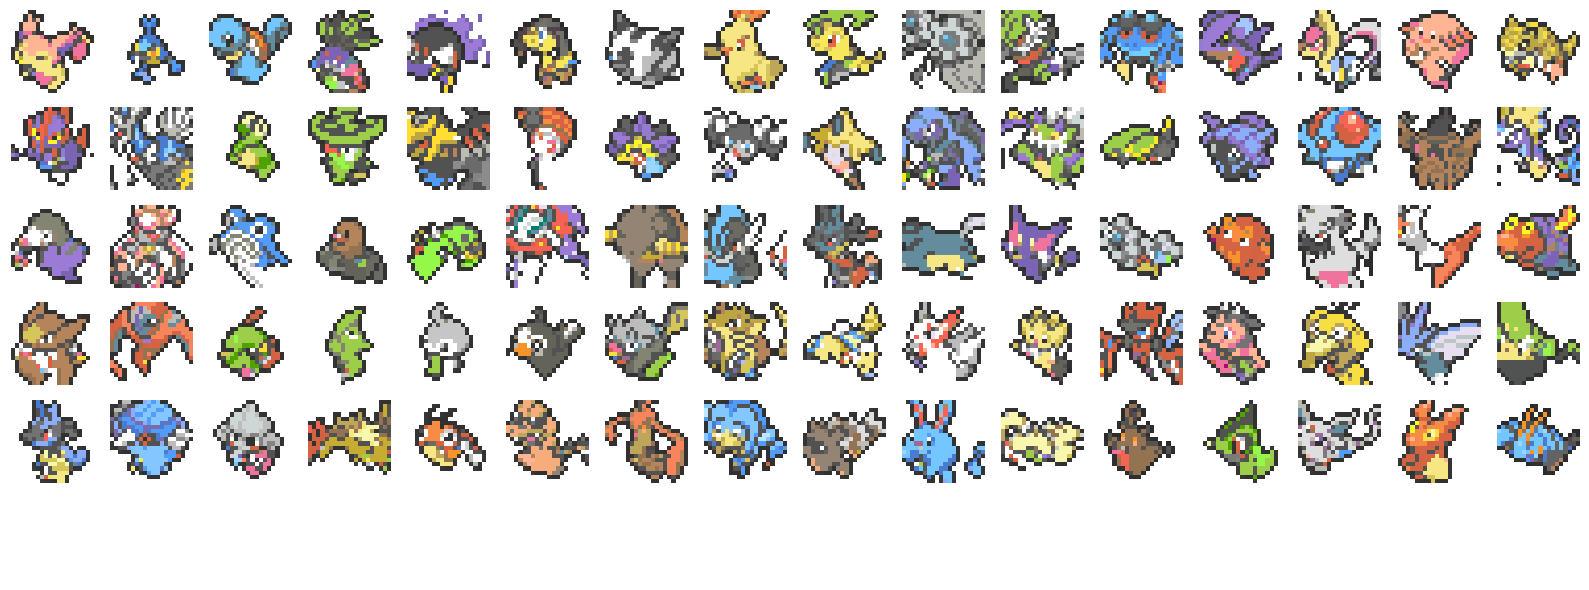

In [16]:
# Visualize generated test images
predicted_images = [pixel_to_image(sequence, colormap) for sequence in results]
show_images(predicted_images)